# introduction

# Data Preprocessing

In this proposed work, we aim to conduct a classification task on musical instruments utilizing a dataset comprised of 900 samples of equally distrubted music instruments and 127 samples for test. The dataset consists of WAV files representing acoustic guitars, drum bass, and cellos recordings.

In [2]:
# data preprocess
import librosa
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# visualize
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# link with google drive to fetch data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


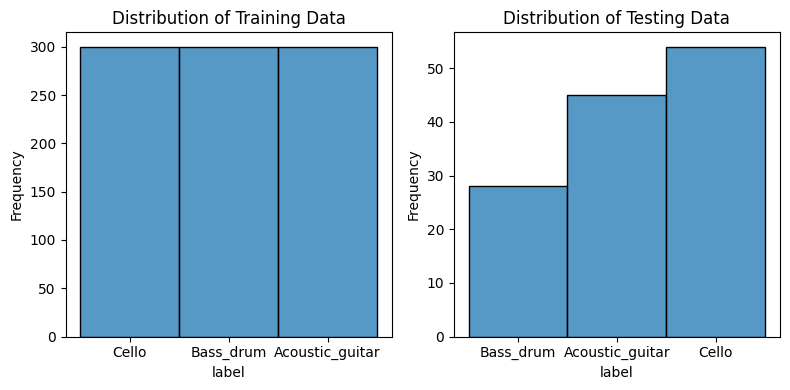

In [4]:
# loading data
df_train = pd.read_csv("/content/drive/MyDrive/datasets/musical_instruments_classification/metadata/train2_metadata.csv")
df_train.shape
df_test = pd.read_csv("/content/drive/MyDrive/datasets/musical_instruments_classification/metadata/test2_metadata.csv")
df_train.shape

# Create a figure and axis object with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plotting the distribution for training data
sns.histplot(df_train['label'], ax=axs[0])
axs[0].set_xlabel('label')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Training Data')

# Plotting the distribution for testing data
sns.histplot(df_test['label'], ax=axs[1])
axs[1].set_xlabel('label')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Testing Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### MFCC

MFCC (Mel-Frequency Cepstral Coefficients) feature extraction plays a crucial role in music classification tasks due to its ability to capture essential characteristics of audio signals in a compact representation. By representing audio signals in terms of MFCCs, we can extract discriminative features that highlight important aspects such as timbre, pitch, and spectral envelope. These features are particularly effective in distinguishing between different musical instruments, as each instrument tends to exhibit unique spectral properties.
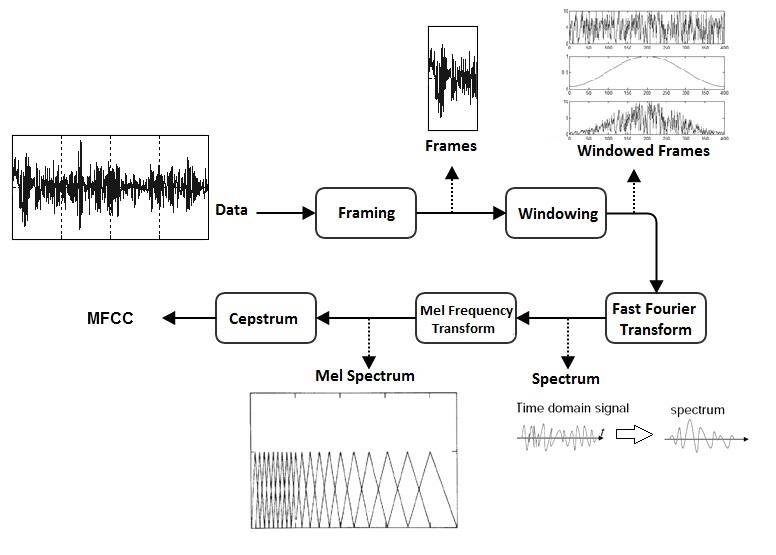


#### extract MFCC

In [5]:
sr = 16000
# Define a function to compute MFCC features for a given audio file
def compute_mfcc(file_path):
    # Load audio file
    audio, _ = librosa.load(file_path)  # Change sr as needed

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Change n_mfcc as needed
    return mfccs

# Define a function to compute MFCC features for a given audio file, padding zeros to match max_file shape
def compute_mfcc_padding(file_path, max_shape):
    # Load audio file
    audio, sr = librosa.load(file_path)  # Change sr as needed

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Change n_mfcc as needed

    # Pad MFCC array to match max_shape
    padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_shape[1] - mfccs.shape[1])), mode='constant')
    return padded_mfccs

# find the largest file
def find_largest_file(directory):
  largest_file = None
  largest_size = 0

  # Iterate over all files in the directory
  for filename in os.listdir(directory):
      filepath = os.path.join(directory, filename)
      # Check if it's a file (not a directory)
      if os.path.isfile(filepath):
          # Get the size of the file
          size = os.path.getsize(filepath)
          # Update largest_file and largest_size if necessary
          if size > largest_size:
              largest_size = size
              largest_file = filepath

  return largest_file

In [6]:
# extract largest file mfcc shape
directory = "/content/drive/MyDrive/datasets/musical_instruments_classification/train"
max_file_name = find_largest_file(directory)
max_file_path = os.path.join(directory, max_file_name)
max_shape = compute_mfcc(max_file_path).shape
max_shape

(13, 1288)

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []

# process the train data to MFCC feature
for index, row in df_train.iterrows():
    file_path = os.path.join(directory, row['fname'])
    mfcc = compute_mfcc_padding(file_path, max_shape)
    X_train.append(mfcc)
    y_train.append(row['label'])

# process the test data to MFCC feature
for index, row in df_test.iterrows():
    file_path = os.path.join(directory, row['fname'])
    mfcc = compute_mfcc_padding(file_path, max_shape)
    X_test.append(mfcc)
    y_test.append(row['label'])

# Convert lists to numpy arrays
X_train = np.array(X_train)
# y_train = np.array(y_train)
X_test = np.array(X_test)
# y_test = np.array(y_test)

# Convert string labels to one-hot encoded vectors
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# Create a dictionary to map labels to their one-hot encodings
y_dict = {label: encoding for label, encoding in zip(label_binarizer.classes_, label_binarizer.transform(label_binarizer.classes_))}

# Reshape the input data to flatten the MFCC features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_flat = np.ravel(y_train)

# Transform one-hot encoded labels to shape of (n_samples,)
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [8]:
# Transform one-hot encoded labels to shape of (n_samples,)
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [9]:
def visualize_mfcc(df, indices, xs, sr=22050):
    num_plots = len(indices)
    plt.figure(figsize=(7 * num_plots, 3))

    for i, (index, x) in enumerate(zip(indices, xs), 1):
        plt.subplot(1, num_plots, i)
        librosa.display.specshow(x, x_axis="time", sr=sr)
        plt.colorbar(format="%+2.f")
        plt.title(df.at[index, 'label'])

    plt.tight_layout()
    plt.show()

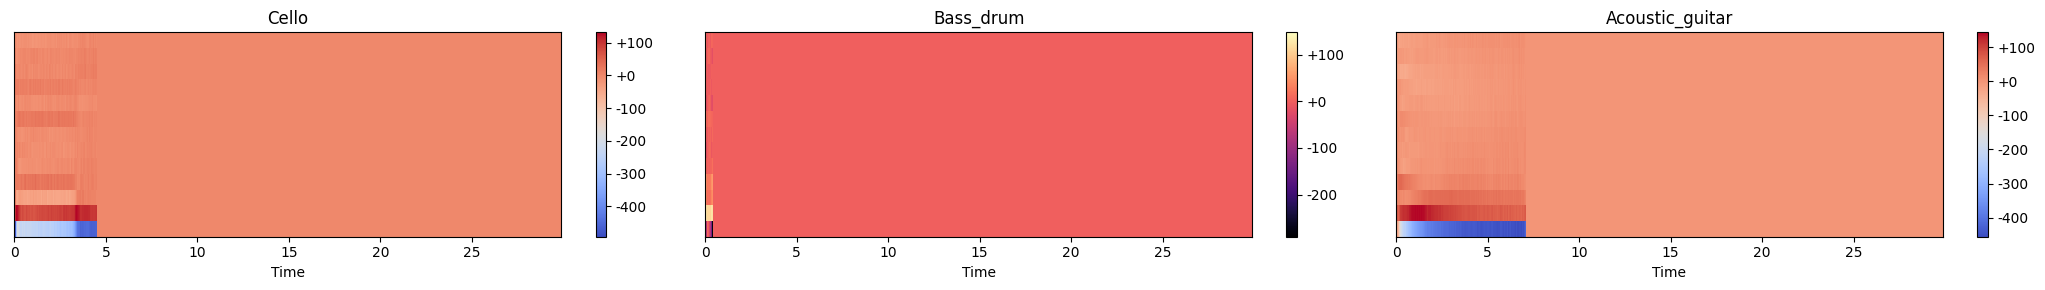

In [10]:
# # show the MFCC of cello and bass drum
index_of_cello = df_train.index[df_train['label'] == 'Cello'].tolist()[0]
index_of_bass_drum = df_train.index[df_train['label'] == 'Bass_drum'].tolist()[0]
index_of_acustic_guitar = df_train.index[df_train['label'] == 'Acoustic_guitar'].tolist()[0]

indices = [index_of_cello, index_of_bass_drum, index_of_acustic_guitar]
x_list = [X_train[index_of_cello], X_train[index_of_bass_drum], X_train[index_of_acustic_guitar]]

visualize_mfcc(df_train, indices, x_list)

we can distinguish easily between drum bass and cello (or acustic guitar) based on the MFCC feature above. on the other hand cello and acustic guitar are both strings instruments so their MFCC may look similiar.

### data normalization

Data normalization is a preprocessing technique commonly used in machine learning to standardize the scale of the features. This is particularly important when dealing with features that have different scales or units, as it can help algorithms converge faster and perform better.

MFCCs are typically numerical values representing different characteristics of audio signals, such as pitch, timbre, and intensity. These coefficients may have different ranges depending on how they were extracted and the characteristics of the audio data.

By normalizing your data using a technique like StandardScaler, you are essentially transforming your data so that each feature has a mean of 0 and a standard deviation of 1. This ensures that all features are on the same scale, making it easier for machine learning algorithms to interpret and learn from the data without being biased towards features with larger scales.



In [11]:
# Normalize the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Logistic Regression

Logistic regression is a statistical method used for binary classification tasks, predicting the probability that an instance belongs to a particular class. It works by modeling the relationship between the independent variables and the probability of the binary outcome using the logistic function. During training, it optimizes the parameters to minimize the difference between predicted probabilities and actual class labels, typically using techniques like maximum likelihood estimation or gradient descent

In [12]:
def plot_error_rates(train_errors, test_errors, best_train_error, best_test_error, best_max_iter_train, best_max_iter_test, range_start, range_end):
    # Plot the error rates
    plt.plot(range(range_start, range_end), train_errors, label='Train Error')
    plt.plot(range(range_start, range_end), test_errors, label='Test Error')
    plt.xlabel('Iterations')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs. Iterations')
    plt.legend()

    # Annotate best train error
    plt.annotate(f'Best Train Error: {best_train_error:.4f}', xy=(best_max_iter_train, best_train_error),
                 xytext=(best_max_iter_train, best_train_error + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Annotate best test error
    plt.annotate(f'Best Test Error: {best_test_error:.4f}', xy=(best_max_iter_test, best_test_error),
                 xytext=(best_max_iter_test, best_test_error + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Lists to store error rates
train_errors = []
test_errors = []

best_train_error = float('inf')
best_test_error = float('inf')
best_max_iter_train = 0
best_max_iter_test = 0

range_start = 1
range_end = 30
for i in range(range_start, range_end):  # Start from 1 as max_iter should be greater than 0
    # Initialize a logistic regression classifier with increased max_iter
    logistic_regression = LogisticRegression(max_iter=i)

    # Train the logistic regression classifier on the training data
    logistic_regression.fit(X_train_scaled, y_train_flat)

    # Predict labels for the training and test data
    y_pred_train_logistic = logistic_regression.predict(X_train_scaled)
    y_pred_test_logistic = logistic_regression.predict(X_test_scaled)

    # Calculate accuracy for training and test data
    accuracy_train_logistic = accuracy_score(y_train_flat, y_pred_train_logistic)
    accuracy_test_logistic = accuracy_score(y_test_flat, y_pred_test_logistic)

    # Calculate train error and test error
    train_error_logistic = 1 - accuracy_train_logistic
    test_error_logistic = 1 - accuracy_test_logistic

    # Append error rates to lists
    train_errors.append(train_error_logistic)
    test_errors.append(test_error_logistic)

    # Update best errors and corresponding max_iter values
    if train_error_logistic < best_train_error:
        best_train_error = train_error_logistic
        best_max_iter_train = i
    if test_error_logistic < best_test_error:
        best_test_error = test_error_logistic
        best_max_iter_test = i

warnings.resetwarnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


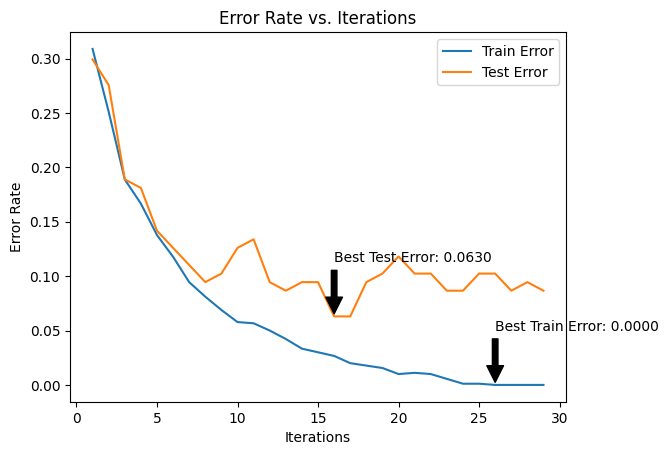

In [18]:
# plot the errors
plot_error_rates(train_errors, test_errors, best_train_error, best_test_error, best_max_iter_train, best_max_iter_test, range_start, range_end)

we can see from the pot that both train error and test error converge till the 7.5th iteration, then the train error keeps converge while the true error not. it indicates on overfitting. there are several methods to avoid overffiting, one is data agumentation.

## data agumentation

Data augmentation is a technique used in machine learning to artificially increase the size of a dataset by applying various transformations to the existing data samples. The goal of data augmentation is to diversify the dataset, providing the model with more varied examples to learn from, which can improve its generalization and robustness.

In [19]:
def amplitude_scale(mfcc_data, scale_factor=0.8):

    # Apply amplitude scaling to MFCC data
    scaled_mfcc = mfcc_data * scale_factor

    return scaled_mfcc

def augment_data(X_train, y_train, sr):

  X_train_agumented = np.copy(X_train)
  y_train_agumented = np.copy(y_train)

  # pitch shift
  for i in range(len(X_train)):
    amplitude_scale_sample = amplitude_scale(X_train[i])
    X_train_agumented = np.append(X_train_agumented, [amplitude_scale_sample], axis=0)
    y_train_agumented = np.append(y_train_agumented, [y_train[i]], axis=0)

  return X_train_agumented, y_train_agumented

X_train_agumented, y_train_agumented = augment_data(X_train=X_train_scaled, y_train=y_train_flat, sr=16000)

In [20]:
# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Lists to store error rates
train_errors = []
test_errors = []

best_train_error = float('inf')
best_test_error = float('inf')
best_max_iter_train = 0
best_max_iter_test = 0

range_start = 1
range_end = 30
for i in range(range_start, range_end):  # Start from 1 as max_iter should be greater than 0
    # Initialize a logistic regression classifier with increased max_iter
    logistic_regression = LogisticRegression(max_iter=i)

    # Train the logistic regression classifier on the training data
    logistic_regression.fit(X_train_agumented, y_train_agumented)

    # Predict labels for the training and test data
    y_pred_train_logistic = logistic_regression.predict(X_train_agumented)
    y_pred_test_logistic = logistic_regression.predict(X_test_scaled)

    # Calculate accuracy for training and test data
    accuracy_train_logistic = accuracy_score(y_train_agumented, y_pred_train_logistic)
    accuracy_test_logistic = accuracy_score(y_test_flat, y_pred_test_logistic)

    # Calculate train error and test error
    train_error_logistic = 1 - accuracy_train_logistic
    test_error_logistic = 1 - accuracy_test_logistic

    # Append error rates to lists
    train_errors.append(train_error_logistic)
    test_errors.append(test_error_logistic)

    # Update best errors and corresponding max_iter values
    if train_error_logistic < best_train_error:
        best_train_error = train_error_logistic
        best_max_iter_train = i
    if test_error_logistic < best_test_error:
        best_test_error = test_error_logistic
        best_max_iter_test = i
warnings.resetwarnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


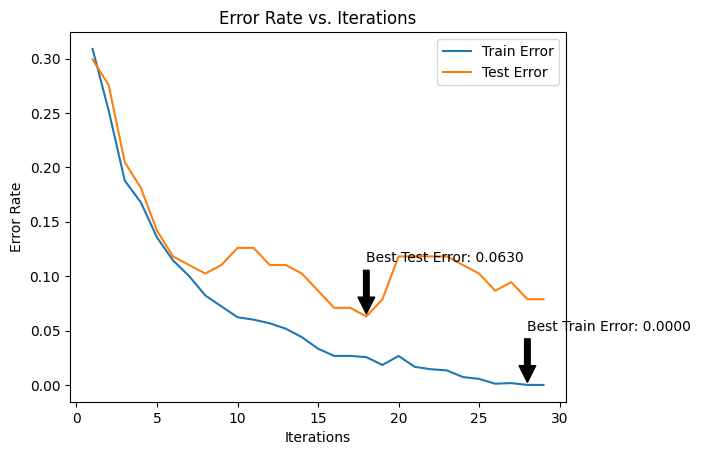

In [21]:
# plot the errors
plot_error_rates(train_errors, test_errors, best_train_error, best_test_error, best_max_iter_train, best_max_iter_test, range_start, range_end)

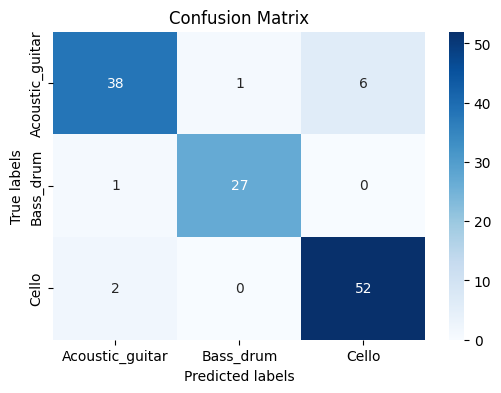

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_test_logistic)

# Get class names from y_dict
class_names = [key for key in y_dict.keys()]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## SVM (SVC)

Support Vector Machine (SVM) is a versatile algorithm used for classification and regression tasks. It excels in finding hyperplanes that separate classes in feature space, maximizing the margin for generalization.Support Vector Classifier (SVC). SVC allows for kernel selection and parameter tuning, offering flexibility for optimal model performance. we exprimented with different kernels:

**1. Linear Kernel:**
  * The linear kernel computes the dot product between two feature vectors.
  *It is suitable for linearly separable data or when the number of features is very large compared to the number of samples.
  * It works well when the relationship between the features and the target variable is approximately linear.

**2. Polynomial Kernel:**
  * The polynomial kernel maps the input features into a higher-dimensional space using polynomial functions.
  * It allows SVM to capture non-linear decision boundaries by introducing interactions between features.

**Radial Basis Function (RBF) Kernel:**
  * The RBF kernel computes the similarity between feature vectors based on the Gaussian (radial basis) function.
  * It is capable of modeling complex decision boundaries in high-dimensional space.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1475: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:897: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(self._

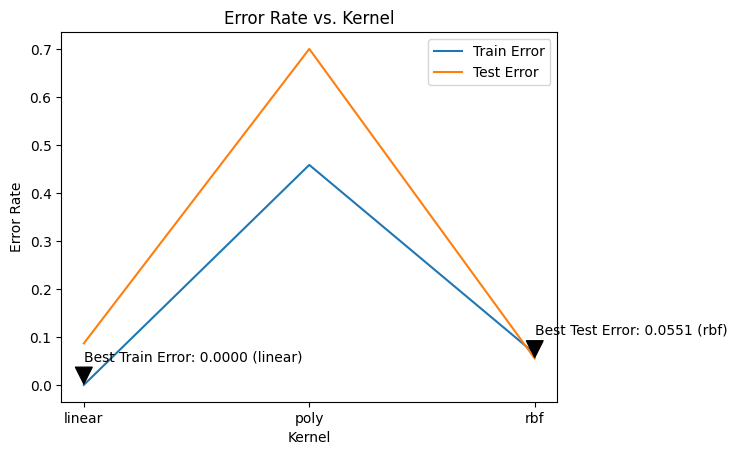

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Lists to store error rates
train_errors = []
test_errors = []

# Lists to store best errors and corresponding kernel
best_train_error = float('inf')
best_test_error = float('inf')
best_kernel_train = ''
best_kernel_test = ''

# Different kernel functions to try
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    # Instantiate SVM classifier with the specified kernel
    svm_classifier = SVC(kernel=kernel)

    # Train the SVM classifier
    svm_classifier.fit(X_train_scaled, y_train_flat)

    # Make predictions on training and test data
    y_pred_train = svm_classifier.predict(X_train_scaled)
    y_pred_test = svm_classifier.predict(X_test_scaled)

    # Calculate training and test errors
    train_error = 1 - accuracy_score(y_train_flat, y_pred_train)
    test_error = 1 - accuracy_score(y_test_flat, y_pred_test)

    # Append errors to lists
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Update best errors and corresponding kernel
    if train_error < best_train_error:
        best_train_error = train_error
        best_kernel_train = kernel
    if test_error < best_test_error:
        best_test_error = test_error
        best_kernel_test = kernel

# Plot the errors for different kernels
plt.plot(kernels, train_errors, label='Train Error')
plt.plot(kernels, test_errors, label='Test Error')
plt.xlabel('Kernel')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Kernel')
plt.legend()

# Annotate best train error
plt.annotate(f'Best Train Error: {best_train_error:.4f} ({best_kernel_train})',
             xy=(best_kernel_train, best_train_error),
             xytext=(best_kernel_train, best_train_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotate best test error
plt.annotate(f'Best Test Error: {best_test_error:.4f} ({best_kernel_test})',
             xy=(best_kernel_test, best_test_error),
             xytext=(best_kernel_test, best_test_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

we can see linear and rbf kernels preform well on the data:

**rbf:** suggests that the decision boundary created by this kernel function generalizes well to unseen data. This indicates that the RBF kernel is suitable for capturing the non-linear relationships present in your data, resulting in good performance.

**linear:** The linear kernel creates a decision boundary that separates classes with a straight line. Despite its simplicity, linear kernels can perform well when the data is linearly separable, meaning the classes can be separated by a hyperplane in the feature space.

**poly:** Polynomial kernels can capture more complex relationships in the data compared to linear kernels but are generally not as flexible as RBF kernels. However, choosing the right parameters for the polynomial kernel, such as the degree of the polynomial, is crucial.we will expirement poly with different degrees to see the effect of the degree on the model.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


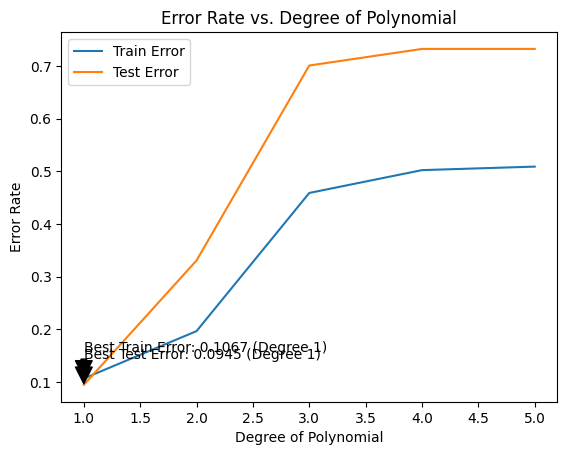

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Lists to store error rates
train_errors = []
test_errors = []

# Best errors and corresponding parameters
best_train_error = float('inf')
best_test_error = float('inf')
best_degree_train = 0
best_degree_test = 0

# Degrees of the polynomial to try
degrees = [1, 2, 3, 4, 5]

for degree in degrees:
    # Instantiate SVM classifier with polynomial kernel of current degree
    svm_classifier = SVC(kernel='poly', degree=degree)

    # Train the SVM classifier
    svm_classifier.fit(X_train_scaled, y_train_flat)

    # Make predictions on training and test data
    y_pred_train = svm_classifier.predict(X_train_scaled)
    y_pred_test = svm_classifier.predict(X_test_scaled)

    # Calculate training and test errors
    train_error = 1 - accuracy_score(y_train_flat, y_pred_train)
    test_error = 1 - accuracy_score(y_test_flat, y_pred_test)

    # Append errors to lists
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Update best errors and corresponding parameters
    if train_error < best_train_error:
        best_train_error = train_error
        best_degree_train = degree
    if test_error < best_test_error:
        best_test_error = test_error
        best_degree_test = degree

# Plot the errors for different degrees of the polynomial
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Degree of Polynomial')
plt.legend()

# Annotate best train error
plt.annotate(f'Best Train Error: {best_train_error:.4f} (Degree {best_degree_train})',
             xy=(best_degree_train, best_train_error),
             xytext=(best_degree_train, best_train_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotate best test error
plt.annotate(f'Best Test Error: {best_test_error:.4f} (Degree {best_degree_test})',
             xy=(best_degree_test, best_test_error),
             xytext=(best_degree_test, best_test_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

When you increase the degree of the polynomial kernel in SVM, you are allowing the decision boundary to become more flexible and capture more complex relationships in the data.

When you have a low degree polynomial (degree 1), the model's capacity to fit the training data is limited. It can't capture complex relationships very well, so it might not fit the training data perfectly. However, this limitation can sometimes be beneficial because it prevents the model from fitting the noise or irrelevant patterns present in the training data. As a result, the model might generalize better to unseen data, leading to lower training error.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


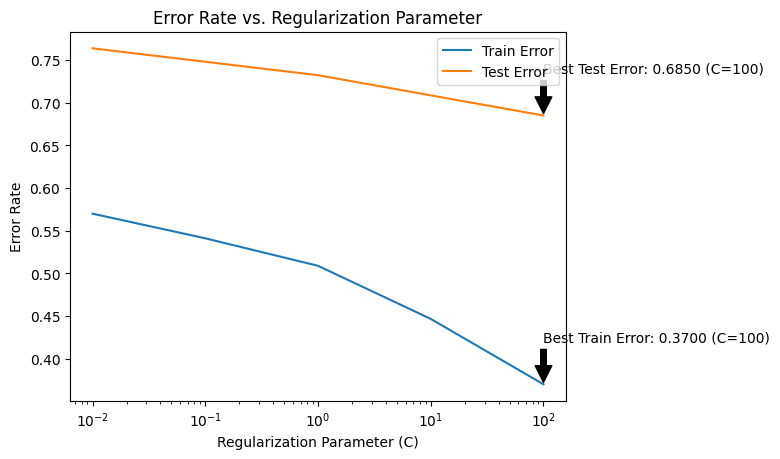

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Lists to store error rates
train_errors = []
test_errors = []

# Lists to store best errors and corresponding kernel
best_train_error = float('inf')
best_test_error = float('inf')
best_kernel_train = ''
best_kernel_test = ''

# Different values for the regularization parameter (C)
regularization_params = [0.01, 0.1, 1, 10, 100]

for C in regularization_params:
    # Instantiate SVM classifier with polynomial kernel and specified C
    svm_classifier = SVC(kernel='poly', degree=5, C=C)

    # Train the SVM classifier
    svm_classifier.fit(X_train_scaled, y_train_flat)

    # Make predictions on training and test data
    y_pred_train = svm_classifier.predict(X_train_scaled)
    y_pred_test = svm_classifier.predict(X_test_scaled)

    # Calculate training and test errors
    train_error = 1 - accuracy_score(y_train_flat, y_pred_train)
    test_error = 1 - accuracy_score(y_test_flat, y_pred_test)

    # Append errors to lists
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Update best errors and corresponding regularization parameter
    if train_error < best_train_error:
        best_train_error = train_error
        best_C_train = C
    if test_error < best_test_error:
        best_test_error = test_error
        best_C_test = C

# Plot the errors for different values of the regularization parameter (C)
plt.plot(regularization_params, train_errors, label='Train Error')
plt.plot(regularization_params, test_errors, label='Test Error')
plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Regularization Parameter')
plt.legend()

# Annotate best train error
plt.annotate(f'Best Train Error: {best_train_error:.4f} (C={best_C_train})',
             xy=(best_C_train, best_train_error),
             xytext=(best_C_train, best_train_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotate best test error
plt.annotate(f'Best Test Error: {best_test_error:.4f} (C={best_C_test})',
             xy=(best_C_test, best_test_error),
             xytext=(best_C_test, best_test_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


## KNN

K-Nearest Neighbors (KNN) is a simple yet effective supervised machine learning algorithm used for classification and regression tasks.
* **K Parameter**: The 'k' in KNN represents the number of nearest neighbors to consider. It's a hyperparameter that needs to be specified before training. Choosing the right 'k' value is crucial, as it can affect the algorithm's performance and its ability to generalize well on unseen data.

* **Distance Metric**: Typically, Euclidean distance is used to measure the distance between data points in the feature space, but other distance metrics like Manhattan distance or Minkowski distance can also be used depending on the problem and data characteristics.



In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define K values and metrics
K_values = [1, 3, 5, 7, 9]
metrics = ['euclidean', 'manhattan', 'chebyshev']
num_metrics = len(metrics)

# Initialize arrays to store train error and test error for each metric and K value
train_errors = np.zeros((num_metrics, len(K_values)))
test_errors = np.zeros((num_metrics, len(K_values)))

# Initialize arrays to store best train and test errors, along with their corresponding K values and metrics
best_train_error = np.inf
best_test_error = np.inf
best_k_train = None
best_metric_train = None
best_k_test = None
best_metric_test = None

# Train Decision Tree classifiers for each metric and K value
for i, metric in enumerate(metrics):
    for j, k in enumerate(K_values):
        # Define KNN classifier with current metric and K value
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

        # Fit KNN classifier on the normalized training data
        knn.fit(X_train_scaled, y_train_flat)

        # Predict labels for the normalized training data
        y_train_pred = knn.predict(X_train_scaled)

        # Calculate train error
        train_error = 1 - accuracy_score(y_train_flat, y_train_pred)

        # Store best train error and corresponding K value and metric
        if train_error < best_train_error:
            best_train_error = train_error
            best_k_train = k
            best_metric_train = metric

        # Predict labels for the normalized test data
        y_test_pred = knn.predict(X_test_scaled)

        # Calculate test error
        test_error = 1 - accuracy_score(y_test_flat, y_test_pred)

        # Store best test error and corresponding K value and metric
        if test_error < best_test_error:
            best_test_error = test_error
            best_k_test = k
            best_metric_test = metric

        train_errors[i, j] = train_error
        test_errors[i, j] = test_error

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


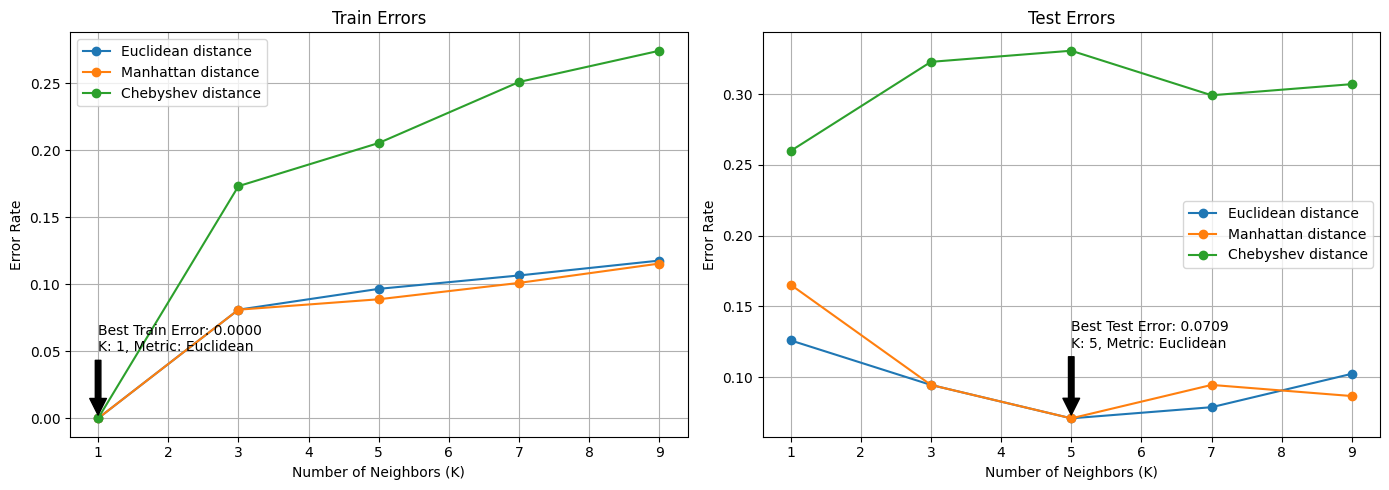

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [27]:
# Plot train errors for each metric
plt.figure(figsize=(14, 5))

# Plot train errors for each metric
plt.subplot(1, 2, 1)
for i, metric in enumerate(metrics):
    plt.plot(K_values, train_errors[i], marker='o', label=f'{metric.capitalize()} distance')
plt.title('Train Errors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

# Annotate best train error
plt.annotate(f'Best Train Error: {best_train_error:.4f}\nK: {best_k_train}, Metric: {best_metric_train.capitalize()}',
             xy=(best_k_train, best_train_error),
             xytext=(best_k_train, best_train_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot test errors for each metric
plt.subplot(1, 2, 2)
for i, metric in enumerate(metrics):
    plt.plot(K_values, test_errors[i], marker='o', label=f'{metric.capitalize()} distance')
plt.title('Test Errors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

# Annotate best test error
plt.annotate(f'Best Test Error: {best_test_error:.4f}\nK: {best_k_test}, Metric: {best_metric_test.capitalize()}',
             xy=(best_k_test, best_test_error),
             xytext=(best_k_test, best_test_error + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

**K value analyze:**

With a lower k, the model tends to "memorize" the training data more effectively. It essentially learns the training instances by heart and makes predictions based on their immediate neighbors. This memorization can lead to a lower training error as the model becomes highly specialized to the training data. However, it might not generalize well to unseen data, leading to higher test error rates (overfitting).

**metric analyze:**

Euclidean distance, by penalizing larger differences more, might have resulted in better performance because it captures the overall dissimilarity more accurately.
Manhattan distance, by summing absolute differences, is robust to outliers and might have also performed well, especially if there are significant differences in various dimensions.
Chebyshev distance, by considering only the maximum difference, might not have captured the overall dissimilarity accurately, leading to poorer performance.


since the music instrument classification task likely involves multiple features (dimensions), Euclidean and Manhattan distances, which capture the overall dissimilarity more accurately, outperformed Chebyshev distance, which only considers the maximum difference along any dimension.

# Decision Trees

In a Decision Tree Classifier, both Gini impurity and entropy are criteria used for splitting a node. These criteria help in determining the best feature and value to split the data at each node of the tree. Here's a brief explanation of each:
* **Gini Impurity**: Measures the probability of misclassification. Favors larger partitions and frequent classes.
* **Entropy**: Measures the level of disorder in data. Tends to create more balanced trees.


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define criterions
criterions = ['gini', 'entropy']
num_criterions = len(criterions)

# Initialize arrays to store train error and test error for each criterion
train_errors = np.zeros((num_criterions))
test_errors = np.zeros((num_criterions))

# Initialize variables to store best train and test error and corresponding criterion
best_train_error = np.inf
best_test_error = np.inf
best_criterion_train = None
best_criterion_test = None

# Train Decision Tree classifiers for each criterion
for i, criterion in enumerate(criterions):
    # Define Decision Tree classifier with current criterion
    decision_tree = DecisionTreeClassifier(criterion=criterion)

    # Fit Decision Tree classifier on the normalized training data
    decision_tree.fit(X_train_scaled, y_train)

    # Predict labels for the normalized training data
    y_train_pred = decision_tree.predict(X_train_scaled)

    # Calculate train error
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    train_errors[i] = train_error

    # Store best train error and corresponding criterion
    if train_error < best_train_error:
        best_train_error = train_error
        best_criterion_train = criterion

    # Predict labels for the normalized test data
    y_test_pred = decision_tree.predict(X_test_scaled)

    # Calculate test error
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    test_errors[i] = test_error

    # Store best test error and corresponding criterion
    if test_error < best_test_error:
        best_test_error = test_error
        best_criterion_test = criterion

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


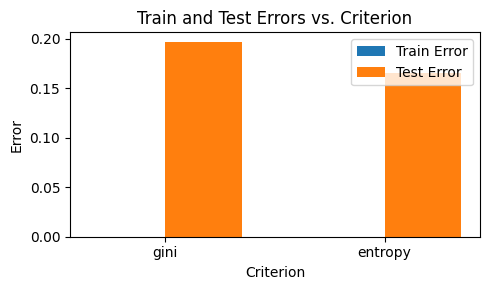

Best Train Error: 0.0000, Criterion: gini
Best Test Error: 0.1654, Criterion: entropy


In [29]:
# Plot the train and test errors for each criterion
plt.figure(figsize=(5, 3))
bar_width = 0.35
index = np.arange(num_criterions)

plt.bar(index, train_errors, bar_width, label='Train Error')
plt.bar(index + bar_width, test_errors, bar_width, label='Test Error')

plt.xlabel('Criterion')
plt.ylabel('Error')
plt.title('Train and Test Errors vs. Criterion')
plt.xticks(index + bar_width / 2, criterions)
plt.legend()
plt.tight_layout()
plt.show()

# Print best train and test errors and their corresponding criteria
print(f"Best Train Error: {best_train_error:.4f}, Criterion: {best_criterion_train}")
print(f"Best Test Error: {best_test_error:.4f}, Criterion: {best_criterion_test}")


This suggests that the model trained with entropy generalizes better to unseen data compared to the one trained with Gini impurity.


One possible reason for this could be that entropy is more sensitive to changes in class probabilities and is better able to capture the structure of the data. It might have resulted in a decision tree that generalizes better to unseen instances by creating more balanced and informative splits.


Another reason could be that entropy tends to produce more balanced trees compared to Gini impurity. A more balanced tree is less likely to overfit the training data and thus can generalize better to new data